In [67]:
import json, os, multiprocessing
from os import path
import matplotlib.pyplot as plt

NUMBER_OF_CPU = multiprocessing.cpu_count()

In [5]:
class SystemInfo:
    def __init__(self, name, before, after, time):
        self.name = name
        self.before = before
        self.after = after
        self.time = time

class ProcessInfo:
    def __init__(self, cpuUsage, memoryUsage, createdTime):
        self.cpuUsage = cpuUsage
        self.memoryUsage = memoryUsage
        self.createdTime = createdTime

In [21]:
def loadFileInDict(filename):
    assert path.exists(filename), "The file you have inputted was not found!"
    info = dict()
    with open(filename) as r:
        data = r.read()
    info = json.loads(data)
    return info

def getSystemInfo(filename):
    systemDict = loadFileInDict(filename)
    infoList = []
    for data in systemDict:
        systemInfo = SystemInfo(data, systemDict[data][0], systemDict[data][1], systemDict[data][2])
        infoList.append(systemInfo)
    return infoList

def getProcessInfo(filename):
    processDict = loadFileInDict(filename)
    processList = []
    for process in processDict["processes"]:
        processInfo = ProcessInfo(process["CPU in use"], process["Memory_usage"], process["Create time"])
        processList.append(processInfo)
    return processList

In [44]:
def plt_comparison(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

In [27]:
SPARK_PROCESS_INFO = "pyspark/processes_info_init.json"
SPARK_SYSTEM_INFO = "pyspark/system_info.json"
DASK_PROCESS_INFO = "dask/processes_info.json"
DASK_SYSTEM_INFO = "dask/system_info.json"

sparkSystemInfo = getSystemInfo(SPARK_SYSTEM_INFO)
sparkProcessInfo = getProcessInfo(SPARK_PROCESS_INFO)
sparkSystemDict = loadFileInDict(SPARK_SYSTEM_INFO)
sparkProcessDict = loadFileInDict(SPARK_PROCESS_INFO)

daskSystemInfo = getSystemInfo(DASK_SYSTEM_INFO)
daskProcessInfo = getProcessInfo(DASK_PROCESS_INFO)
daskSystemDict = loadFileInDict(DASK_SYSTEM_INFO)
daskProcessDict = loadFileInDict(DASK_PROCESS_INFO)

# Compare time of execution

In [28]:
def get_time_stats(sysDict, sysList):
    times = []
    process_names = list(sysDict.keys())
    for process in sysList:
        times.append(process.time)
    return process_names, times

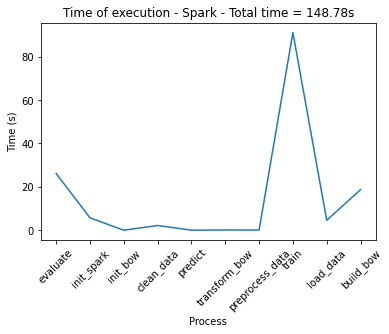

In [45]:
process_names_spark, times_spark = get_time_stats(sparkSystemDict, sparkSystemInfo)
plt_comparison(process_names_spark, times_spark, "Process", "Time (s)", f"Time of execution - Spark - Total time = {'{:.2f}'.format(sum(times_spark))}s")

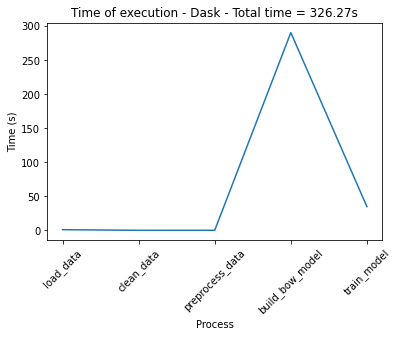

In [47]:
process_names_dask, times_dask = get_time_stats(daskSystemDict, daskSystemInfo)
plt_comparison(process_names_dask, times_dask, "Process", "Time (s)", f"Time of execution - Dask - Total time = {'{:.2f}'.format(sum(times_dask))}s")

# Compare CPU usage

In [103]:
def get_CPU_usage(systemList):
    cpuUsage = []
    for process in systemList:
        cpu = float(process.after['CPU in use'][:-1])
        cpuUsage.append(cpu)
    return cpuUsage

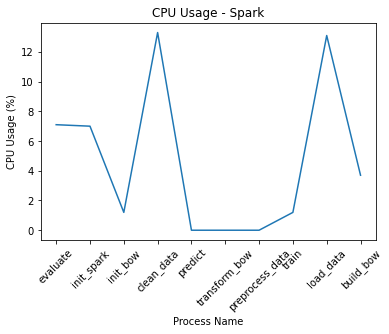

In [104]:
cpuUsageSpark = get_CPU_usage(sparkSystemInfo)
plt_comparison(process_names_spark, cpuUsageSpark, "Process Name", "CPU Usage (%)", "CPU Usage - Spark")

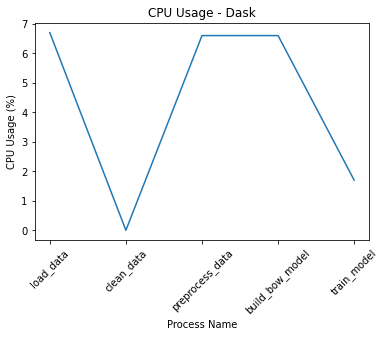

In [105]:
cpuUsageDask = get_CPU_usage(daskSystemInfo)
plt_comparison(process_names_dask, cpuUsageDask, "Process Name", "CPU Usage (%)", "CPU Usage - Dask")

# Compare Memory Usage

In [106]:
def get_Memory_usage(systemList):
    memoryUsage = []
    for process in systemList:
        memory = float(process.after['Memory in use'][:-3])
        memoryUsage.append(memory)
    return memoryUsage

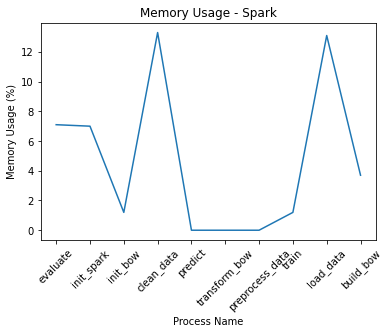

In [109]:
memoryUsageSpark = get_Memory_usage(sparkSystemInfo)
plt_comparison(process_names_spark, cpuUsageSpark, "Process Name", "Memory Usage (%)", "Memory Usage - Spark")

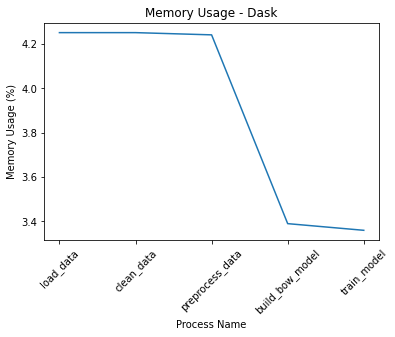

In [110]:
memoryUsageDask = get_Memory_usage(daskSystemInfo)
plt_comparison(process_names_dask, memoryUsageDask, "Process Name", "Memory Usage (%)", "Memory Usage - Dask")